**логистическая регрессия, метод градиентного спуска** 

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)

# генерируем набор данных

(1024, 2)

(1024, 1)

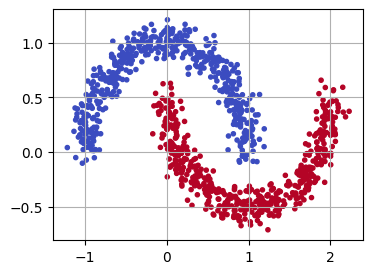

In [2]:
from sklearn.datasets import make_moons
X,target = make_moons(n_samples=1024, noise=.09)

#from sklearn.datasets import make_blobs
#X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

target = target.reshape(-1,1)
display(X.shape, target.shape)

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [3]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

from sklearn.preprocessing   import StandardScaler
X = StandardScaler().fit(X).transform(X)

display( ( X.min(),np.mean(X),np.median(X),X.max() ) )

(-1.974, -0.000, 0.007, 1.989)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

## модель

$$f(u) = \frac{1}{1+\exp(-u)}$$


$$a(x,w) = f\left(\sum\limits_{i=1} x_i \cdot w_i + w_0\right)$$

$$\frac{\partial f}{\partial u} = \frac{\exp(-u)}{\left(1+\exp(-u)\right)^2} $$

Text(0.5, 1.0, 'd_sigmoid')

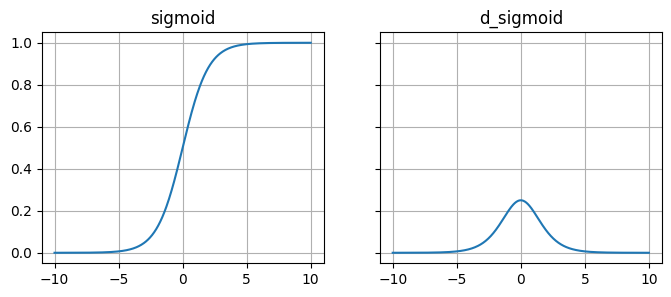

In [5]:
sigmoid = lambda x: 1./(1. + np.exp(-x))
d_sigmoid = lambda x: np.square(sigmoid(x))*np.exp(-x)

x=np.linspace(-10,10,500)
fig,ax = plt.subplots(ncols=2, figsize=(8,3),sharey=True)
ax[0].plot(x,sigmoid(x))
ax[0].grid()
ax[0].set_title('sigmoid')

ax[1].plot(x,d_sigmoid(x))
ax[1].grid()
ax[1].set_title('d_sigmoid')

In [6]:
# activation, d_activation = sigmoid, d_sigmoid 

In [7]:
class LogisticRegression:
    
    def __init__( self, weight=np.array([]), score_threshold=.5 ):
        self._weight = weight
        self._score_threshold = score_threshold
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return self._act( self._state(x) )
    
    def score_partial(self,x): # частные производные модели по её параметрам
        return  self._d_act( self._state(x) )*x

    def _state(self,x): return x.dot(self._weight)
    
    def predict(self,x): 
        return (self.score(x)>self._score_threshold).astype(np.uint8)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value

    def weight_init(self,n): 
        self._weight = rng.normal(size=(n,1),scale=1e-3)
        return self
            

    @staticmethod
    def _act(x): return 1./(1.+np.exp(-x))
    
    @classmethod
    def _d_act(cls,x): return np.square(cls._act(x))*np.exp(-x)
    
    @property
    def score_threshold(self): return self._score_threshold

    @score_threshold.setter
    def score_threshold(self,value): self._score_threshold = value

## обучаем модель

функция потери - кросс-энтропия

$$L = BCE(y,o) = -y\cdot log2(o) - (1-y) \cdot log2(1-o)  $$

$$  \nabla L = \frac{\partial L}{\partial w} = -\frac{o-y }{o (o-1)}\cdot \frac{\partial o}{\partial w}$$ 

In [8]:
class BCELoss:  # кросс-энтропия

    @staticmethod
    def score(y,o): 
        with np.errstate(divide='ignore',invalid='ignore'):
            # доопределяем нулями логарифм для аргументов меньше или равно 0
            l0 = np.where( o<1., (1-y)*np.log2(1.-o), 0. )
            l1 = np.where( o>0., y*np.log2(o),        0. ) 
        return -(l1+l0).sum()/len(y)
    
    @staticmethod
    def partial( y, o, p, ): # градиент функции потери,
        # o = model(x,w)
        # p = model_partial(x,w)
        with np.errstate(divide='ignore',invalid='ignore'):
            d = o*(o-1)
            d = np.where(d!=0.,(1./d), .0 )
        g = -p.T.dot((o-y)*d)
        g /= np.abs(g).max()
        return g

изменение весов

$$\Delta w_t = \eta \cdot ( \nabla L + \rho\cdot W_{t-1} ) + \mu\cdot \Delta w_{t-1}$$

In [9]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

In [10]:
class TrainGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss   
        self._lr = .1     
       
    
    def fit( self, X, target, lr=1e-2, n_epoch=512, acc_min=.99, ): 
        # n_epoch - максимальное число циклов обучения
        # acc_min - порог минимально допустимой погрешности модели
        self._lr = lr   # скорость обучения

        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight_init(n_param)

        # начальное значение ф-ции потери
        loss_history = [ self._loss.score(target,self._model.score(X)) ]
        acc_history = [ accuracy_score(target,self._model.predict(X)) ]

        for i in tqdm(range(n_epoch)): # цикл обучения
            self._fit_epoch(X,target) # корректируем веса модели
            loss_history.append(  self._loss.score(target,self._model.score(X)) ) # считаем значение ф-ции потери
            acc_history.append( accuracy_score(target,self._model.predict(X)) )

            if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
                acc = acc_history[-1]
                print(f'step {i+1}/{n_epoch}: acc {acc:.3f}, threshold {acc_min:.3f} reached\n')
                break   
                
        return (acc_history,loss_history), self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X) ) 
        self._weight_adjust(g) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g):
        self._model.weight = self._model.weight - self._lr*g   # корректируем параметры
        return self
        

In [11]:
class TrainSGD(TrainGD):
    
    def __init__(self,model,loss):
        super().__init__(model,loss)
        self._dw = np.array([]) # изменение весов на предыдущем шаге
        self._mu = 0. # коэфициент момента
        self._rho = 0. # коэфициент регуляризации
        self._bs = 1  # размер пакета данных для одного цикла обучения
        
    
    def fit( self, X, target, lr=1e-4, n_epoch=1024, acc_min=.999, batch_size=10,rho=1e-2,mu=1e-3 ): 
        # n_epoch - максимальное число циклов обучения
        # loss_min - порог минимально допустимой погрешности модели
        self._mu = mu # коэфициент момента
        self._rho = rho # коэфициент регуляризации
        self._bs = batch_size # размер пакета данных для одного цикла обучения
        n_param = X.shape[1] # размер вектора признаков
        self._dw = np.zeros((n_param,1)) # изменение весов на предыдущем шаге 
        return super().fit(X, target, lr,n_epoch,acc_min)
    
    def _fit_epoch(self,X,target):
        for x,y in self._get_batch(X,target): # режем датасет на батчи
            super()._fit_epoch(x,y)
        return self
        
    def _weight_adjust(self,g):
        self._dw = self._lr*(g + self._rho*self._model.weight ) + self._mu * self._dw
        self._model.weight = self._model.weight - self._dw   # корректируем параметры
        return self
    
    # генератор батчей
    def _get_batch(self,x,y): 
        n_samples = len(y) # количество учебных пар
        batch_count = np.ceil( n_samples/self._bs).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield x[idx,:],y[idx,:]
        

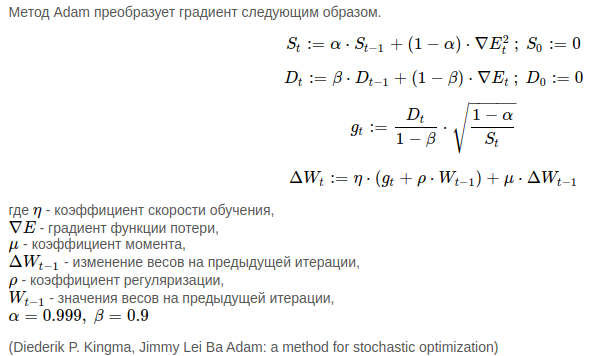



In [12]:
class TrainAdam(TrainSGD):
    
    def __init__(self,model,loss):
        super().__init__(model,loss)
        self._a = .999
        self._b = .9
        self._D = np.array([])
        self._S = np.array([])
            
    def fit( self, X, target, lr=1e-4, n_epoch=1024, acc_min=.999, batch_size=10,rho=1e-2,mu=1e-3,a=.999,b=.9 ): 
        self._a = a
        self._b = b
        n_param = X.shape[1] # размер вектора признаков
        self._D = np.zeros((n_param,1))
        self._S = np.zeros((n_param,1))
        return super().fit(X, target, lr,n_epoch,acc_min)
        
    def _weight_adjust(self,g):
        self._S = self._a*self._S + (1-self._a)*np.square(g)
        self._D = self._b*self._D + (1-self._b)*g
        g_ = self._D/(1.-self._b)*np.sqrt( (1.-self._a)/self._S )
        
        self._dw = self._lr*(g_ + self._rho*self._model.weight ) + self._mu * self._dw
        self._model.weight = self._model.weight - self._dw   # корректируем параметры
        return self

In [13]:
from sklearn.preprocessing import PolynomialFeatures

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures( 
        degree=3, 
        interaction_only=False, 
        include_bias=True,
    ).fit( X_train )

In [14]:
(acc_history,loss_history), model = TrainAdam(
        model=LogisticRegression(),
        loss=BCELoss()
    ).fit( 
        poly.transform(X_train),
        target_train,
        batch_size=len(X_train)//5,
        lr=1e-2
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

step 190/1024: acc 1.000, threshold 0.999 reached



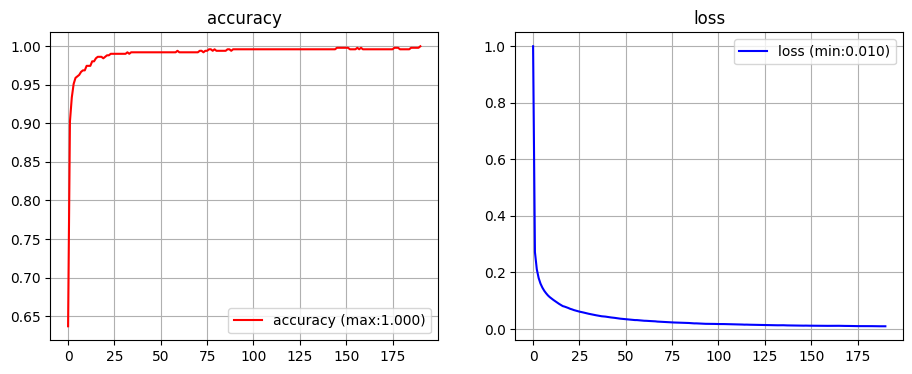

In [15]:
# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

In [16]:
# оптимальный порог скора 

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve( target_train, model.score(poly.transform(X_train)) )

#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
display(optimal_threshold)

model.score_threshold = optimal_threshold

0.509

## тестируем

In [17]:
from sklearn.metrics import classification_report

predicted =  model.predict(poly.transform(X_test))
print(classification_report( target_test, predicted) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       252

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



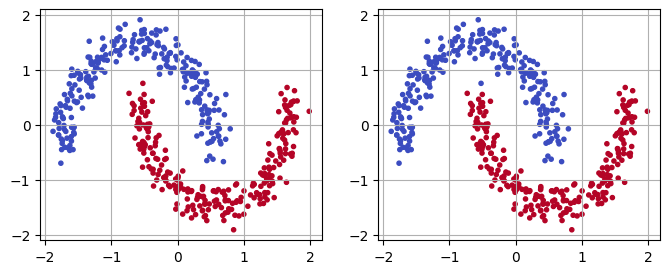

In [18]:
fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].grid()

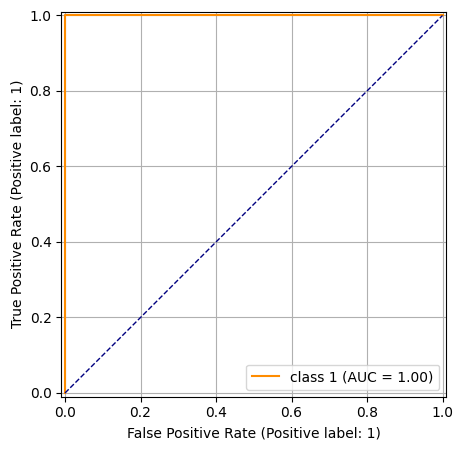

In [19]:
from sklearn.metrics import RocCurveDisplay

score = model.score(poly.transform(X_test))

fig,ax = plt.subplots( figsize=(6,5),)
RocCurveDisplay.from_predictions( target_test, score, name='class 1', color='darkorange', ax=ax )
ax.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
ax.grid()

## карта скоров

In [20]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

In [21]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score(poly.transform(xy))
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

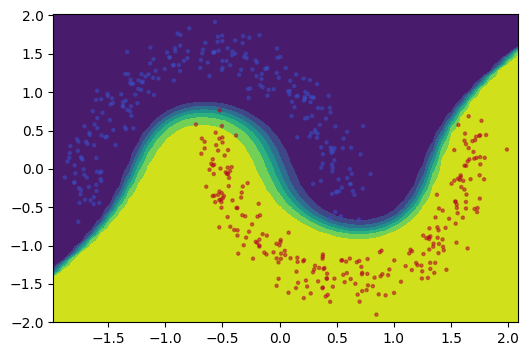

In [22]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

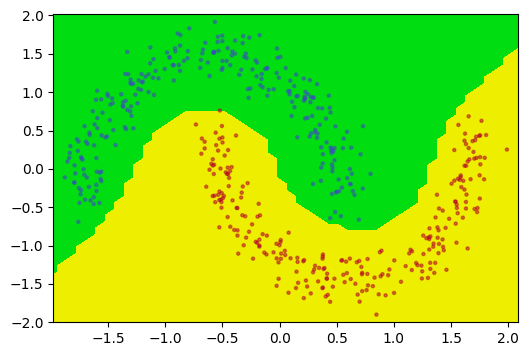

In [23]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict(poly.transform(xy)).reshape(n,n) 

fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )